In [1]:
import torch
import torch.utils
import torch.utils.data
from tqdm.auto import tqdm
from torch import nn
import argparse
import torch.nn.functional as F
import utils
import dataset
import os
import matplotlib.pyplot as plt

/Users/kshitijvaidya/miniconda3/envs/cs726env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import numpy as np

dataPath = 'data/albatross.npy'
data = np.load(dataPath)
print(data.shape)

(32561, 16, 4)


In [3]:
dataPath2 = 'data/albatross_prior_samples.npy'
data2 = np.load(dataPath2)
print(data2.shape)

(32561, 64)


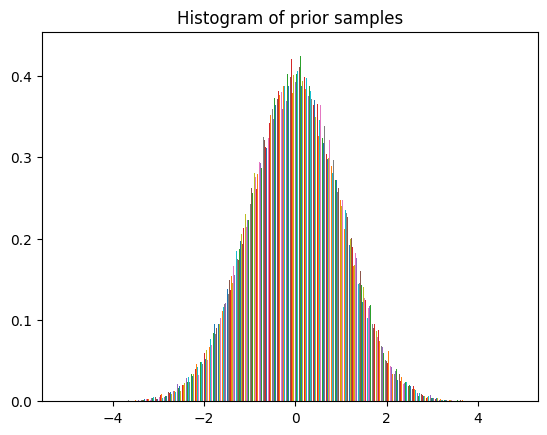

In [4]:
# Make a histogram of the prior sample data
plt.hist(data2, bins=100, density=True)
plt.title('Histogram of prior samples')
plt.show()

In [5]:
moonDataX, moonDataY = dataset.load_dataset('moons')
print(type(moonDataX))
print(moonDataX.shape)
print(type(moonDataY))
print(moonDataY.shape)

<class 'torch.Tensor'>
torch.Size([8000, 2])
<class 'torch.Tensor'>
torch.Size([8000])


In [6]:
# Define the time embedding class to generate sinusoidal embeddings
class TimeEmbedding(nn.Module):
    def __init__(self, numDim : int):
        super().__init__()
        self.numDim = numDim

    def forward(self, time : torch.Tensor):
        '''
        Input:
            time: (batchSize, 1)
        Output:
            embedding: (batchSize, numDim)
        '''
        # Generate the sinusoidal embeddings
        embedding = torch.zeros(time.shape[0], self.numDim)
        for i in range(self.numDim):
            if i % 2 == 0:
                embedding[:, i] = torch.sin(time / 10000 ** (i / self.numDim))
            else:
                embedding[:, i] = torch.cos(time / 10000 ** ((i - 1) / self.numDim))
        return embedding


In [7]:
# Test the time embedding class to generate sinusoidal embeddings
timeEmbedding = TimeEmbedding(10)
timeSteps = torch.arange(0, 100)
print(timeSteps.shape)
embeddings = timeEmbedding(timeSteps)
print(embeddings.shape)
print(embeddings[2, :])

torch.Size([100])
torch.Size([100, 10])
tensor([ 0.9093, -0.4161,  0.3117,  0.9502,  0.0502,  0.9987,  0.0080,  1.0000,
         0.0013,  1.0000])


In [8]:
# Write the Noise Scheduler class that will be used for training the DDPM Model
class NoiseScheduler():
    """
    Noise scheduler for the DDPM model

    Args:
        num_timesteps: int, the number of timesteps
        type: str, the type of scheduler to use
        **kwargs: additional arguments for the scheduler

    This object sets up all the constants like alpha, beta, sigma, etc. required for the DDPM model
    
    """
    def __init__(self, num_timesteps=50, type="linear", **kwargs):

        self.num_timesteps = num_timesteps
        self.type = type

        if type == "linear":
            self.init_linear_schedule(**kwargs)
        else:
            raise NotImplementedError(f"{type} scheduler is not implemented") # change this if you implement additional schedulers


    def init_linear_schedule(self, beta_start, beta_end):
        """
        Precompute whatever quantities are required for training and sampling
        """
        self.betaSchedule = torch.linspace(beta_start, beta_end, self.num_timesteps)
        self.alpha = 1 - self.betaSchedule
        self.alphaProd = torch.cumprod(self.alpha, 0)
        self.sqrtCumprodAlpha = np.sqrt(self.alphaProd)
        self.sqrtAlpha = np.sqrt(self.alpha)
        self.sqrtOneMinusAlpha = np.sqrt(1 - self.alpha)
        self.sqrtOneMinusAlphaProd = torch.sqrt(1 - self.alphaProd)

    def __len__(self):
        return self.num_timesteps

In [9]:
noiseScheduler = NoiseScheduler(num_timesteps=50, 
                                type="linear", 
                                beta_start=0.0001, 
                                beta_end=0.02)
# print(noiseScheduler.betaSchedule)
print(noiseScheduler.alpha)

tensor([0.9999, 0.9995, 0.9991, 0.9987, 0.9983, 0.9979, 0.9975, 0.9971, 0.9967,
        0.9962, 0.9958, 0.9954, 0.9950, 0.9946, 0.9942, 0.9938, 0.9934, 0.9930,
        0.9926, 0.9922, 0.9918, 0.9914, 0.9910, 0.9906, 0.9902, 0.9897, 0.9893,
        0.9889, 0.9885, 0.9881, 0.9877, 0.9873, 0.9869, 0.9865, 0.9861, 0.9857,
        0.9853, 0.9849, 0.9845, 0.9841, 0.9837, 0.9832, 0.9828, 0.9824, 0.9820,
        0.9816, 0.9812, 0.9808, 0.9804, 0.9800])


In [10]:
class MLPModel(nn.Module):
    def __init__(self, inputDim : int, timeEmbedDim : int, hiddenDim : int = 128):
        super().__init__()
        self.inputDim = inputDim
        self.timeEmbedDim = timeEmbedDim
        self.hiddenDim = hiddenDim
        self.fc1 = nn.Linear(inputDim + timeEmbedDim, hiddenDim // 2)
        self.fc2 = nn.Linear(hiddenDim // 2, hiddenDim)
        self.fc3 = nn.Linear(hiddenDim, hiddenDim)
        self.fc4 = nn.Linear(hiddenDim, hiddenDim // 2)
        self.fc5 = nn.Linear(hiddenDim // 2, inputDim)
        self.activation = nn.ReLU()
    
    def forward(self, input : torch.Tensor) -> torch.Tensor:
        '''
        Input:
            input: (batchSize, inputDim)
        Output:
            output: (batchSize, inputDim)
        '''
        output = self.fc1(input)
        output = self.activation(output)
        output = self.fc2(output)
        output = self.activation(output)
        output = self.fc3(output)
        output = self.activation(output)
        output = self.fc4(output)
        output = self.activation(output)
        output = self.fc5(output)
        return output


In [42]:
class AdvancedMLPModel(nn.Module):
    def __init__(self, inputDim: int, timeEmbedDim: int, hiddenDim: int = 256):
        super().__init__()
        self.inputDim = inputDim
        self.timeEmbedDim = timeEmbedDim
        self.hiddenDim = hiddenDim
        # Keep the rest of the model same, change the activation function to SiLU
        self.fc1 = nn.Linear(inputDim + timeEmbedDim, hiddenDim // 2)
        self.fc2 = nn.Linear(hiddenDim // 2, hiddenDim)
        self.fc3 = nn.Linear(hiddenDim, hiddenDim)
        self.fc4 = nn.Linear(hiddenDim, hiddenDim // 2)
        self.fc5 = nn.Linear(hiddenDim // 2, inputDim)
        self.activation = nn.SiLU()
    
    def forward(self, input : torch.Tensor) -> torch.Tensor:
        '''
        Input:
            input: (batchSize, inputDim)
        Output:
            output: (batchSize, inputDim)
        '''
        output = self.fc1(input)
        output = self.activation(output)
        output = self.fc2(output)
        output = self.activation(output)
        output = self.fc3(output)
        output = self.activation(output)
        output = self.fc4(output)
        output = self.activation(output)
        output = self.fc5(output)
        return output

        

In [54]:
class ResidualMLPModel(nn.Module):
    def __init__(self, inputDim: int, timeEmbedDim: int, hiddenDim: int = 256):
        super().__init__()
        self.inputDim = inputDim
        self.timeEmbedDim = timeEmbedDim
        self.hiddenDim = hiddenDim

        # Input projection layer
        self.input_proj = nn.Linear(inputDim + timeEmbedDim, hiddenDim)

        # Main network with residual blocks
        self.residual_blocks = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hiddenDim, hiddenDim),  # Concatenate time embedding
                nn.SiLU(),
                nn.Linear(hiddenDim, hiddenDim)
            )
            for _ in range(4)  # Number of residual blocks
        ])

        # Output projection layer
        self.output_proj = nn.Linear(hiddenDim, inputDim)

    def forward(self, x):
        """
        Forward pass of the model.
        Args:
            x: Input tensor of shape (batch_size, inputDim)
            time: Time tensor of shape (batch_size, 1)
        Returns:
            Output tensor of shape (batch_size, inputDim)
        """
        # Time embedding
        # time_embed = self.time_embed(time)  # (batch_size, timeEmbedDim)

        # Input projection
        h = self.input_proj(x)  # (batch_size, hiddenDim)

        # Residual blocks
        for block in self.residual_blocks:
            # Concatenate time embedding
            # h_input = torch.cat([h, time_embed], dim=-1)  # (batch_size, hiddenDim + timeEmbedDim)
            # Residual connection
            h = h + block(h)  # (batch_size, hiddenDim)

        # Output projection
        out = self.output_proj(h)  # (batch_size, inputDim)

        return out

In [55]:
class DDPM(nn.Module):
    def __init__(self, n_dim=3, n_steps=200):
        """
        Noise prediction network for the DDPM

        Args:
            n_dim: int, the dimensionality of the data
            n_steps: int, the number of steps in the diffusion process
        We have separate learnable modules for `time_embed` and `model`. `time_embed` can be learned or a fixed function as well

        """
        super().__init__()
        self.n_dim = n_dim
        self.n_steps = n_steps
        self.time_embed_dim = n_dim
        self.time_embed = TimeEmbedding(self.time_embed_dim)
        # self.model = MLPModel(n_dim, self.time_embed_dim)
        # self.model = AdvancedMLPModel(n_dim, self.time_embed_dim)
        self.model = ResidualMLPModel(n_dim, self.time_embed_dim)

    def forward(self, x, t):
        """
        Args:
            x: torch.Tensor, the input data tensor [batch_size, n_dim]
            t: torch.Tensor, the timestep tensor [batch_size]

        Returns:
            torch.Tensor, the predicted noise tensor [batch_size, n_dim]
        """
        # Get the time embeddings
        timeEmbeddings = self.time_embed(t)
        # Concatenate the input data with the time embeddings
        input = torch.cat([x, timeEmbeddings], dim=-1)
        # Get the predicted noise
        noise = self.model(input)
        return noise

In [ ]:
# Define a test model
# ddpm = DDPM(n_dim=3, n_steps=200)
ddpm = DDPM(n_dim=3, n_steps=200)
x = torch.randn(10, 3)
t = torch.randint(0, 200, (10,))
print(x.shape)
print(t.shape)
output = ddpm(x, t)
print(output.shape)

torch.Size([10, 3])
torch.Size([10])
torch.Size([10, 3])


In [36]:
def train(model, noise_scheduler, dataloader, optimizer, epochs, run_name):
    """
    Train the model and save the model and necessary plots

    Args:
        model: DDPM, model to train
        noise_scheduler: NoiseScheduler, scheduler for the noise
        dataloader: torch.utils.data.DataLoader, dataloader for the dataset
        optimizer: torch.optim.Optimizer, optimizer to use
        epochs: int, number of epochs to train the model
        run_name: str, path to save the model
    """
    model.train()
    lossFunction = nn.MSELoss()
    device = next(model.parameters()).device
    for epoch in range(epochs):
        epochLoss = 0
        for x in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
            x = x.to(device)
            # Define the random time step
            timesteps = torch.randint(0, noise_scheduler.num_timesteps, 
                                      (x.shape[0],), device=device)
            # Get the noise
            noise = torch.randn_like(x)
            noisyInput = (noise_scheduler.sqrtCumprodAlpha[timesteps, None] * x 
                          + noise_scheduler.sqrtOneMinusAlphaProd[timesteps, None] * noise)
            optimizer.zero_grad()
            predictedNoise = model(noisyInput, timesteps)
            loss = lossFunction(predictedNoise, noise)
            loss.backward()
            optimizer.step()
            epochLoss += loss.item()
        print(f"Epoch {epoch+1}/{epochs} Loss: {epochLoss/len(dataloader)}")
    torch.save(model.state_dict(), f'models/{run_name}.pth')

In [37]:
print(moonDataX.shape)

torch.Size([8000, 2])


In [ ]:
# Define the dataset and dataloader
batchSize = 64
n_steps = 200
dataset = moonDataX
n_dim = dataset.shape[1]
dataloader = torch.utils.data.DataLoader(dataset, 
                                         batch_size=batchSize, 
                                         shuffle=True)
# Define the model
ddpm = DDPM(n_dim=n_dim, n_steps=n_steps)
# Define the optimizer
optimizer = torch.optim.Adam(ddpm.parameters(), lr=1e-3)
# Train the model
train(ddpm, noiseScheduler, 
      dataloader, optimizer, epochs=100, 
      run_name="moon_test1")

In [16]:
@torch.no_grad()
def sample(model, n_samples, noise_scheduler, return_intermediate=False):
    """
    Sample from the model
    
    Args:
        model: DDPM
        n_samples: int
        noise_scheduler: NoiseScheduler
        return_intermediate: bool
    Returns:
        torch.Tensor, samples from the model [n_samples, n_dim]

    If `return_intermediate` is `False`,
            torch.Tensor, samples from the model [n_samples, n_dim]
    Else
        the function returns all the intermediate steps in the diffusion process as well 
        Return: [[n_samples, n_dim]] x n_steps
        Optionally implement return_intermediate=True, will aid in visualizing the intermediate steps
    """  
    device = next(model.parameters()).device
    model.eval()
    samples = [] if return_intermediate else None
    numDim = model.model.inputDim
    inputs = torch.randn(n_samples, numDim, device=device)

    for timestep in reversed(range(0, noise_scheduler.num_timesteps)):
        timesteps = torch.full((n_samples,), timestep, device=device)
        noisePred = model(inputs, timesteps)
        inputs = ((inputs - ((1.0 - noise_scheduler.alpha[timestep]) / noise_scheduler.sqrtOneMinusAlphaProd[timestep]) * noisePred)
                  / noise_scheduler.sqrtAlpha[timestep])
        if return_intermediate:
            samples.append(inputs.clone().cpu().numpy())
    if return_intermediate:
        return samples
    return inputs

    

In [46]:
# Test the sampling function
trainedModel = DDPM(n_dim=2, n_steps=200)
trainedModel.load_state_dict(torch.load('models/moon_test1.pth'))
# trainedModel.eval()
samples = sample(trainedModel, 8000, noiseScheduler, 
                 return_intermediate=True)
# print(samples.shape)

In [47]:
print(len(samples))
from utils import animateScatter2d
from IPython.display import HTML

figure, axes = plt.subplots(1, 1, figsize=(10, 10))
animation = animateScatter2d(figure, axes, samples, title="Diffusion Process")
plt.close()
display(HTML(animation.to_html5_video()))

50


In [19]:
print(samples[0])

[[-0.56744015  0.41226712]
 [-0.81494683  0.5977882 ]
 [-0.79600304 -0.1396695 ]
 ...
 [-0.73454136 -1.1057215 ]
 [-0.08221516 -0.7260329 ]
 [ 2.0161088  -0.79315597]]


In [25]:
class ConditionalMLPModel(nn.Module):
    def __init__(self, inputDim : int, numClasses: int, timeEmbedDim : int, hiddenDim : int = 128):
        super().__init__()
        self.inputDim = inputDim
        self.timeEmbedDim = timeEmbedDim
        self.hiddenDim = hiddenDim
        self.numClasses = numClasses
        self.fc1 = nn.Linear(inputDim + timeEmbedDim + numClasses, hiddenDim // 2)
        self.fc2 = nn.Linear(hiddenDim // 2, hiddenDim)
        self.fc3 = nn.Linear(hiddenDim, hiddenDim)
        self.fc4 = nn.Linear(hiddenDim, hiddenDim // 2)
        self.fc5 = nn.Linear(hiddenDim // 2, inputDim)
        self.activation = nn.ReLU()
    
    def forward(self, input : torch.Tensor) -> torch.Tensor:
        '''
        Input:
            input: (batchSize, inputDim)
        Output:
            output: (batchSize, inputDim)
        '''
        output = self.fc1(input)
        output = self.activation(output)
        output = self.fc2(output)
        output = self.activation(output)
        output = self.fc3(output)
        output = self.activation(output)
        output = self.fc4(output)
        output = self.activation(output)
        output = self.fc5(output)
        return output

In [26]:
class ConditionalDDPM(nn.Module):
    def __init__(self, n_dim=3, n_steps=200,
                 n_classes=2):
        """
        Conditional Noise prediction network for the DDPM

        Args:
            n_dim: int, the dimensionality of the data
            n_steps: int, the number of steps in the diffusion process
            n_classes: int, the number of classes
        We have separate learnable modules for `time_embed`, `class_embed` and `model`. `time_embed` can be learned or a fixed function as well
        """
        super().__init__()
        self.n_dim = n_dim
        self.n_steps = n_steps
        self.time_embed_dim = n_dim
        self.class_embed_dim = n_classes
        self.time_embed = TimeEmbedding(self.time_embed_dim)
        self.class_embed = nn.Embedding(n_classes, n_dim)
        self.model = ConditionalMLPModel(n_dim, self.time_embed_dim, self.class_embed_dim)
    
    def forward(self, x, t, y):
        """
        Args:
            x: torch.Tensor, the input data tensor [batch_size, n_dim]
            t: torch.Tensor, the timestep tensor [batch_size]
            y: torch.Tensor, the class tensor [batch_size]

        Returns:
            torch.Tensor, the predicted noise tensor [batch_size, n_dim]
        """
        # Get the time embeddings
        timeEmbeddings = self.time_embed(t)
        # Get the class embeddings
        classEmbeddings = self.class_embed(y)
        # Concatenate the input data with the time embeddings and class embeddings
        input = torch.cat([x, classEmbeddings, timeEmbeddings], dim=-1)
        # Get the predicted noise
        noise = self.model(input)
        return noise

In [27]:
def trainConditional(model, noise_scheduler, dataloader, optimizer, epochs, run_name):
    """
    Train the conditional model and save the model and necessary plots

    Args:
        model: ConditionalDDPM, model to train
        noise_scheduler: NoiseScheduler, scheduler for the noise
        dataloader: torch.utils.data.DataLoader, dataloader for the dataset
        optimizer: torch.optim.Optimizer, optimizer to use
        epochs: int, number of epochs to train the model
        run_name: str, path to save the model
    """
    model.train()
    lossFunction = nn.MSELoss()
    device = next(model.parameters()).device
    for epoch in range(epochs):
        epochLoss = 0
        for x, y in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
            x = x.to(device)
            y = y.to(device)
            # Define the random time step
            timesteps = torch.randint(0, noise_scheduler.num_timesteps, 
                                      (x.shape[0],), device=device)
            # Get the noise
            noise = torch.randn_like(x)
            noisyInput = (noise_scheduler.sqrtCumprodAlpha[timesteps, None] * x 
                          + noise_scheduler.sqrtOneMinusAlphaProd[timesteps, None] * noise)
            optimizer.zero_grad()
            predictedNoise = model(noisyInput, timesteps, y)
            loss = lossFunction(predictedNoise, noise)
            loss.backward()
            optimizer.step()
            epochLoss += loss.item()
        print(f"Epoch {epoch+1}/{epochs} Loss: {epochLoss/len(dataloader)}")
    torch.save(model.state_dict(), f'models/{run_name}.pth')

In [31]:
@torch.no_grad()
def sampleConditional(model, n_samples, noise_scheduler, n_classes, return_intermediate=False):
    """
    Sample from the conditional model
    
    Args:
        model: ConditionalDDPM
        n_samples: int
        noise_scheduler: NoiseScheduler
        n_classes: int
        return_intermediate: bool
    Returns:
        torch.Tensor, samples from the model [n_samples, n_dim]

    If `return_intermediate` is `False`,
            torch.Tensor, samples from the model [n_samples, n_dim]
    Else
        the function returns all the intermediate steps in the diffusion process as well 
        Return: [[n_samples, n_dim]] x n_steps
        Optionally implement return_intermediate=True, will aid in visualizing the intermediate steps
    """  
    device = next(model.parameters()).device
    model.eval()
    samples = [] if return_intermediate else None
    numDim = model.model.inputDim
    inputs = torch.randn(n_samples, numDim, device=device)
    y = torch.randint(0, n_classes, (n_samples,), device=device)

    for timestep in reversed(range(0, noise_scheduler.num_timesteps)):
        timesteps = torch.full((n_samples,), timestep, device=device)
        noisePred = model(inputs, timesteps, y)
        inputs = ((inputs - ((1.0 - noise_scheduler.alpha[timestep]) / noise_scheduler.sqrtOneMinusAlphaProd[timestep]) * noisePred)
                  / noise_scheduler.sqrtAlpha[timestep])
        if return_intermediate:
            samples.append(inputs.clone().cpu().numpy())
    if return_intermediate:
        return samples
    return inputs

In [29]:
# Define a test model
conditionalDDPM = ConditionalDDPM(n_dim=2, n_steps=200, n_classes=2)
x = moonDataX
t = torch.randint(0, 200, (moonDataX.shape[0],))
y = moonDataY
print(x.shape)
print(t.shape)
print(y.shape)
dataloader = torch.utils.data.DataLoader(list(zip(x, y)), 
                                         batch_size=batchSize, 
                                         shuffle=True)
# Define the optimizer
optimizer = torch.optim.Adam(conditionalDDPM.parameters(), lr=1e-3)
# Train the conditional model
trainConditional(conditionalDDPM, noiseScheduler,
                 dataloader, optimizer, epochs=100,
                 run_name="moon_test_conditional")

torch.Size([8000, 2])
torch.Size([8000])
torch.Size([8000])


Epoch 1/100: 100%|██████████| 125/125 [00:00<00:00, 265.09it/s]


Epoch 1/100 Loss: 0.6925090396404266


Epoch 2/100: 100%|██████████| 125/125 [00:00<00:00, 301.62it/s]


Epoch 2/100 Loss: 0.5541635718345642


Epoch 3/100: 100%|██████████| 125/125 [00:00<00:00, 316.12it/s]


Epoch 3/100 Loss: 0.5380264773368836


Epoch 4/100: 100%|██████████| 125/125 [00:00<00:00, 325.98it/s]


Epoch 4/100 Loss: 0.5259314985275269


Epoch 5/100: 100%|██████████| 125/125 [00:00<00:00, 327.19it/s]


Epoch 5/100 Loss: 0.525557311296463


Epoch 6/100: 100%|██████████| 125/125 [00:00<00:00, 327.61it/s]


Epoch 6/100 Loss: 0.5209580824375153


Epoch 7/100: 100%|██████████| 125/125 [00:00<00:00, 327.82it/s]


Epoch 7/100 Loss: 0.5133593339920044


Epoch 8/100: 100%|██████████| 125/125 [00:00<00:00, 328.58it/s]


Epoch 8/100 Loss: 0.5253728692531585


Epoch 9/100: 100%|██████████| 125/125 [00:00<00:00, 327.65it/s]


Epoch 9/100 Loss: 0.5289018468856812


Epoch 10/100: 100%|██████████| 125/125 [00:00<00:00, 328.05it/s]


Epoch 10/100 Loss: 0.525268784046173


Epoch 11/100: 100%|██████████| 125/125 [00:00<00:00, 327.54it/s]


Epoch 11/100 Loss: 0.5197290110588074


Epoch 12/100: 100%|██████████| 125/125 [00:00<00:00, 327.49it/s]


Epoch 12/100 Loss: 0.5105629050731659


Epoch 13/100: 100%|██████████| 125/125 [00:00<00:00, 326.62it/s]


Epoch 13/100 Loss: 0.5111211392879486


Epoch 14/100: 100%|██████████| 125/125 [00:00<00:00, 326.67it/s]


Epoch 14/100 Loss: 0.5191740550994873


Epoch 15/100: 100%|██████████| 125/125 [00:00<00:00, 326.59it/s]


Epoch 15/100 Loss: 0.511659677028656


Epoch 16/100: 100%|██████████| 125/125 [00:00<00:00, 267.05it/s]


Epoch 16/100 Loss: 0.5058685576915741


Epoch 17/100: 100%|██████████| 125/125 [00:00<00:00, 326.85it/s]


Epoch 17/100 Loss: 0.5136357700824737


Epoch 18/100: 100%|██████████| 125/125 [00:00<00:00, 324.98it/s]


Epoch 18/100 Loss: 0.5056514890193939


Epoch 19/100: 100%|██████████| 125/125 [00:00<00:00, 315.20it/s]


Epoch 19/100 Loss: 0.528027065038681


Epoch 20/100: 100%|██████████| 125/125 [00:00<00:00, 325.81it/s]


Epoch 20/100 Loss: 0.5071485443115235


Epoch 21/100: 100%|██████████| 125/125 [00:00<00:00, 325.97it/s]


Epoch 21/100 Loss: 0.5176339311599731


Epoch 22/100: 100%|██████████| 125/125 [00:00<00:00, 327.33it/s]


Epoch 22/100 Loss: 0.5021545214653015


Epoch 23/100: 100%|██████████| 125/125 [00:00<00:00, 327.65it/s]


Epoch 23/100 Loss: 0.5066837911605835


Epoch 24/100: 100%|██████████| 125/125 [00:00<00:00, 326.70it/s]


Epoch 24/100 Loss: 0.5069298958778381


Epoch 25/100: 100%|██████████| 125/125 [00:00<00:00, 319.60it/s]


Epoch 25/100 Loss: 0.5134584460258483


Epoch 26/100: 100%|██████████| 125/125 [00:00<00:00, 326.56it/s]


Epoch 26/100 Loss: 0.5146445941925049


Epoch 27/100: 100%|██████████| 125/125 [00:00<00:00, 320.56it/s]


Epoch 27/100 Loss: 0.5122019391059875


Epoch 28/100: 100%|██████████| 125/125 [00:00<00:00, 299.40it/s]


Epoch 28/100 Loss: 0.519935397863388


Epoch 29/100: 100%|██████████| 125/125 [00:00<00:00, 287.01it/s]


Epoch 29/100 Loss: 0.5058662447929382


Epoch 30/100: 100%|██████████| 125/125 [00:00<00:00, 302.42it/s]


Epoch 30/100 Loss: 0.5202567312717438


Epoch 31/100: 100%|██████████| 125/125 [00:00<00:00, 327.34it/s]


Epoch 31/100 Loss: 0.49822980546951295


Epoch 32/100: 100%|██████████| 125/125 [00:00<00:00, 328.45it/s]


Epoch 32/100 Loss: 0.5027151138782501


Epoch 33/100: 100%|██████████| 125/125 [00:00<00:00, 328.32it/s]


Epoch 33/100 Loss: 0.5153452501296997


Epoch 34/100: 100%|██████████| 125/125 [00:00<00:00, 281.12it/s]


Epoch 34/100 Loss: 0.4988603744506836


Epoch 35/100: 100%|██████████| 125/125 [00:00<00:00, 326.37it/s]


Epoch 35/100 Loss: 0.5160186567306518


Epoch 36/100: 100%|██████████| 125/125 [00:00<00:00, 329.06it/s]


Epoch 36/100 Loss: 0.5001451210975647


Epoch 37/100: 100%|██████████| 125/125 [00:00<00:00, 324.94it/s]


Epoch 37/100 Loss: 0.496085070848465


Epoch 38/100: 100%|██████████| 125/125 [00:00<00:00, 329.36it/s]


Epoch 38/100 Loss: 0.5080756068229675


Epoch 39/100: 100%|██████████| 125/125 [00:00<00:00, 329.13it/s]


Epoch 39/100 Loss: 0.5133254957199097


Epoch 40/100: 100%|██████████| 125/125 [00:00<00:00, 328.45it/s]


Epoch 40/100 Loss: 0.5004359698295593


Epoch 41/100: 100%|██████████| 125/125 [00:00<00:00, 327.32it/s]


Epoch 41/100 Loss: 0.501467673778534


Epoch 42/100: 100%|██████████| 125/125 [00:00<00:00, 327.42it/s]


Epoch 42/100 Loss: 0.5221342256069184


Epoch 43/100: 100%|██████████| 125/125 [00:00<00:00, 327.89it/s]


Epoch 43/100 Loss: 0.5070048830509186


Epoch 44/100: 100%|██████████| 125/125 [00:00<00:00, 327.46it/s]


Epoch 44/100 Loss: 0.5141552355289459


Epoch 45/100: 100%|██████████| 125/125 [00:00<00:00, 327.29it/s]


Epoch 45/100 Loss: 0.5082431535720825


Epoch 46/100: 100%|██████████| 125/125 [00:00<00:00, 325.76it/s]


Epoch 46/100 Loss: 0.5197813367843628


Epoch 47/100: 100%|██████████| 125/125 [00:00<00:00, 325.83it/s]


Epoch 47/100 Loss: 0.516613552570343


Epoch 48/100: 100%|██████████| 125/125 [00:00<00:00, 327.70it/s]


Epoch 48/100 Loss: 0.5053032326698303


Epoch 49/100: 100%|██████████| 125/125 [00:00<00:00, 327.28it/s]


Epoch 49/100 Loss: 0.5071843981742858


Epoch 50/100: 100%|██████████| 125/125 [00:00<00:00, 320.50it/s]


Epoch 50/100 Loss: 0.5161264998912811


Epoch 51/100: 100%|██████████| 125/125 [00:00<00:00, 328.69it/s]


Epoch 51/100 Loss: 0.5150807502269745


Epoch 52/100: 100%|██████████| 125/125 [00:00<00:00, 277.34it/s]


Epoch 52/100 Loss: 0.5046525263786316


Epoch 53/100: 100%|██████████| 125/125 [00:00<00:00, 328.36it/s]


Epoch 53/100 Loss: 0.501725182056427


Epoch 54/100: 100%|██████████| 125/125 [00:00<00:00, 328.64it/s]


Epoch 54/100 Loss: 0.5133384418487549


Epoch 55/100: 100%|██████████| 125/125 [00:00<00:00, 328.04it/s]


Epoch 55/100 Loss: 0.5159240798950195


Epoch 56/100: 100%|██████████| 125/125 [00:00<00:00, 328.29it/s]


Epoch 56/100 Loss: 0.5098312013149261


Epoch 57/100: 100%|██████████| 125/125 [00:00<00:00, 326.76it/s]


Epoch 57/100 Loss: 0.5037159698009491


Epoch 58/100: 100%|██████████| 125/125 [00:00<00:00, 327.38it/s]


Epoch 58/100 Loss: 0.5097079858779907


Epoch 59/100: 100%|██████████| 125/125 [00:00<00:00, 327.23it/s]


Epoch 59/100 Loss: 0.5180073521137237


Epoch 60/100: 100%|██████████| 125/125 [00:00<00:00, 328.80it/s]


Epoch 60/100 Loss: 0.5030917661190033


Epoch 61/100: 100%|██████████| 125/125 [00:00<00:00, 329.68it/s]


Epoch 61/100 Loss: 0.4932273061275482


Epoch 62/100: 100%|██████████| 125/125 [00:00<00:00, 327.70it/s]


Epoch 62/100 Loss: 0.5222248854637146


Epoch 63/100: 100%|██████████| 125/125 [00:00<00:00, 320.71it/s]


Epoch 63/100 Loss: 0.5016144056320191


Epoch 64/100: 100%|██████████| 125/125 [00:00<00:00, 321.98it/s]


Epoch 64/100 Loss: 0.4992722249031067


Epoch 65/100: 100%|██████████| 125/125 [00:00<00:00, 330.03it/s]


Epoch 65/100 Loss: 0.5106141090393066


Epoch 66/100: 100%|██████████| 125/125 [00:00<00:00, 327.07it/s]


Epoch 66/100 Loss: 0.5086661138534546


Epoch 67/100: 100%|██████████| 125/125 [00:00<00:00, 328.55it/s]


Epoch 67/100 Loss: 0.5054215004444123


Epoch 68/100: 100%|██████████| 125/125 [00:00<00:00, 327.39it/s]


Epoch 68/100 Loss: 0.5142391715049743


Epoch 69/100: 100%|██████████| 125/125 [00:00<00:00, 330.00it/s]


Epoch 69/100 Loss: 0.5026335301399231


Epoch 70/100: 100%|██████████| 125/125 [00:00<00:00, 276.57it/s]


Epoch 70/100 Loss: 0.5102242693901062


Epoch 71/100: 100%|██████████| 125/125 [00:00<00:00, 328.85it/s]


Epoch 71/100 Loss: 0.49950943422317506


Epoch 72/100: 100%|██████████| 125/125 [00:00<00:00, 321.60it/s]


Epoch 72/100 Loss: 0.5105408067703248


Epoch 73/100: 100%|██████████| 125/125 [00:00<00:00, 329.56it/s]


Epoch 73/100 Loss: 0.5039556212425232


Epoch 74/100: 100%|██████████| 125/125 [00:00<00:00, 328.27it/s]


Epoch 74/100 Loss: 0.49380897855758665


Epoch 75/100: 100%|██████████| 125/125 [00:00<00:00, 326.09it/s]


Epoch 75/100 Loss: 0.5047428314685821


Epoch 76/100: 100%|██████████| 125/125 [00:00<00:00, 326.86it/s]


Epoch 76/100 Loss: 0.5204843094348908


Epoch 77/100: 100%|██████████| 125/125 [00:00<00:00, 330.20it/s]


Epoch 77/100 Loss: 0.49879155492782595


Epoch 78/100: 100%|██████████| 125/125 [00:00<00:00, 327.58it/s]


Epoch 78/100 Loss: 0.5145712769031525


Epoch 79/100: 100%|██████████| 125/125 [00:00<00:00, 294.05it/s]


Epoch 79/100 Loss: 0.5118131427764893


Epoch 80/100: 100%|██████████| 125/125 [00:00<00:00, 328.24it/s]


Epoch 80/100 Loss: 0.4988993389606476


Epoch 81/100: 100%|██████████| 125/125 [00:00<00:00, 321.44it/s]


Epoch 81/100 Loss: 0.5098424189090729


Epoch 82/100: 100%|██████████| 125/125 [00:00<00:00, 325.00it/s]


Epoch 82/100 Loss: 0.5106205098628998


Epoch 83/100: 100%|██████████| 125/125 [00:00<00:00, 327.45it/s]


Epoch 83/100 Loss: 0.5122738308906555


Epoch 84/100: 100%|██████████| 125/125 [00:00<00:00, 253.19it/s]


Epoch 84/100 Loss: 0.4968861873149872


Epoch 85/100: 100%|██████████| 125/125 [00:00<00:00, 325.18it/s]


Epoch 85/100 Loss: 0.5151640696525573


Epoch 86/100: 100%|██████████| 125/125 [00:00<00:00, 323.33it/s]


Epoch 86/100 Loss: 0.5015599529743194


Epoch 87/100: 100%|██████████| 125/125 [00:00<00:00, 324.40it/s]


Epoch 87/100 Loss: 0.49857466006278994


Epoch 88/100: 100%|██████████| 125/125 [00:00<00:00, 327.75it/s]


Epoch 88/100 Loss: 0.503289005279541


Epoch 89/100: 100%|██████████| 125/125 [00:00<00:00, 325.77it/s]


Epoch 89/100 Loss: 0.5191924469470978


Epoch 90/100: 100%|██████████| 125/125 [00:00<00:00, 319.06it/s]


Epoch 90/100 Loss: 0.5106041820049286


Epoch 91/100: 100%|██████████| 125/125 [00:00<00:00, 329.56it/s]


Epoch 91/100 Loss: 0.5089240450859069


Epoch 92/100: 100%|██████████| 125/125 [00:00<00:00, 327.32it/s]


Epoch 92/100 Loss: 0.5172716579437255


Epoch 93/100: 100%|██████████| 125/125 [00:00<00:00, 325.45it/s]


Epoch 93/100 Loss: 0.5164502229690552


Epoch 94/100: 100%|██████████| 125/125 [00:00<00:00, 328.80it/s]


Epoch 94/100 Loss: 0.4941180303096771


Epoch 95/100: 100%|██████████| 125/125 [00:00<00:00, 329.61it/s]


Epoch 95/100 Loss: 0.5043572351932526


Epoch 96/100: 100%|██████████| 125/125 [00:00<00:00, 327.91it/s]


Epoch 96/100 Loss: 0.5002129733562469


Epoch 97/100: 100%|██████████| 125/125 [00:00<00:00, 328.16it/s]


Epoch 97/100 Loss: 0.5093271870613099


Epoch 98/100: 100%|██████████| 125/125 [00:00<00:00, 326.75it/s]


Epoch 98/100 Loss: 0.514053786277771


Epoch 99/100: 100%|██████████| 125/125 [00:00<00:00, 330.94it/s]


Epoch 99/100 Loss: 0.5120829038619995


Epoch 100/100: 100%|██████████| 125/125 [00:00<00:00, 281.39it/s]

Epoch 100/100 Loss: 0.5122237052917481


In [32]:
# Sample from the conditional model
trainedModel = ConditionalDDPM(n_dim=2, n_steps=200, n_classes=2)
trainedModel.load_state_dict(torch.load('models/moon_test_conditional.pth'))
samples = sampleConditional(trainedModel, 8000, noiseScheduler, 2,
                            return_intermediate=True)
# print(samples.shape)
figure, axes = plt.subplots(1, 1, figsize=(10, 10))
animation = animateScatter2d(figure, axes, samples, title="Classification Diffusion Process")
plt.close()
display(HTML(animation.to_html5_video()))